# Métodos ensemble:

1. Cargar los datos MNIST y dividirlos en un conjunto de entrenamiento, un conjunto de validación y un conjunto de test (por ejemplo, utilizar 50.000 instancias para entrenamiento, 10.000 para validación y 10.000 para pruebas). Luego, entrenar varios clasificadores, como un clasificador Random Forest, un clasificador Extra-Trees y un clasificador SVM. A continuación, intentar combinarlos en un conjunto que supere a cada clasificador individual en el conjunto de validación, utilizando votación soft o hard. Una vez que haya encontrado uno, probarlo en el conjunto de pruebas. ¿Cuánto mejor se desempeña en comparación con los clasificadores individuales?


In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
X, y = mnist["data"], mnist["target"]

y = y.astype(int)

display(y)

/Users/juan/Library/Python/3.9/lib/python/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


array([5, 0, 4, ..., 4, 5, 6])

In [2]:
from sklearn.model_selection import train_test_split

X_prep, X_test, y_prep, y_test = train_test_split(X,y, test_size=10000, random_state=42) #10.000 para test

X_train, X_val, y_train, y_val = train_test_split(X_prep,y_prep, test_size=10000, random_state=42) # de lo que nos quedo sacamos 10.0000 para validacion y el resto queda en train. descartamos prep

In [3]:
# RandomForest
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)

print ( "Accuracy de Random Forest:", accuracy_score(y_val, y_pred_rf))

Accuracy de Random Forest: 0.9692


In [4]:
# ExtraTrees
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier()
et_clf.fit(X_train, y_train)
y_pred_et = et_clf.predict(X_val)

print ( "Accuracy de ExtraTrees:", accuracy_score(y_val, y_pred_et))

Accuracy de ExtraTrees: 0.9714


In [5]:
# SVM

from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
lin_svc.fit(X_train, y_train)
y_pred_lin_svc = lin_svc.predict(X_val)

print ("Accuracy de SVM:", accuracy_score(y_val, y_pred_lin_svc))

# Mal accuracy, baja el rendimiento del VotingClassifier

Accuracy de SVM: 0.8699


/Users/juan/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
# Boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hb_clf = HistGradientBoostingClassifier()
hb_clf.fit(X_train,y_train)
y_pred_hb_clf = hb_clf.predict(X_val)

print ( "Accuracy de Boosting:", accuracy_score(y_val, y_pred_hb_clf))

Accuracy de Bosting: 0.9775


In [8]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('RandomForest', rf_clf), ('ExtraTrees', et_clf), ('HGB', hb_clf)], voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('RandomForest', RandomForestClassifier()),
                             ('ExtraTrees', ExtraTreesClassifier()),
                             ('HGB', HistGradientBoostingClassifier())])

In [9]:
y_pred_voting = voting_clf.predict(X_val)

print ("Accuracy voting h", accuracy_score(y_val, y_pred_voting))

Accuracy voting h 0.9745


In [10]:
from sklearn.ensemble import VotingClassifier

voting_clf_sft = VotingClassifier(
    estimators=[('RandomForest', rf_clf), ('ExtraTrees', et_clf), ('HGB', hb_clf)], voting='soft'
)
voting_clf_sft.fit(X_train, y_train)

y_pred_voting_sft = voting_clf_sft.predict(X_val)

print ("Accuracy voting soft", accuracy_score(y_val, y_pred_voting_sft))

Accuracy voting soft 0.9776



2. Ejecutar los clasificadores individuales del ejercicio anterior para hacer predicciones en el conjunto de validación y crear un nuevo conjunto de entrenamiento con las predicciones resultantes: cada instancia de entrenamiento es un vector que contiene el conjunto de predicciones de todos los clasificadores para una imagen, y el objetivo es la clase de la imagen. Entrenar un clasificador en este nuevo conjunto de entrenamiento. ¡Felicidades, acaba de entrenar un blender, y junto con los clasificadores forma un conjunto de stacking! Ahora evaluar el conjunto en el conjunto de pruebas. Para cada imagen en el conjunto de pruebas, hacer predicciones con todos los clasificadores, y luego alimentar las predicciones al mezclador para obtener las predicciones del conjunto. ¿Cómo se compara con el clasificador de votación que entrenó anteriormente?


In [12]:
X_blender = list(zip(y_pred_hb_clf, y_pred_et, y_pred_rf))
y_blender = y_val

X_blender = np.array(X_blender)

print(X_blender)

[[5 5 5]
 [8 8 8]
 [2 2 2]
 ...
 [7 7 7]
 [6 6 6]
 [7 7 7]]


In [13]:
ext_blender = ExtraTreesClassifier()
ext_blender.fit(X_blender, y_blender)

ExtraTreesClassifier()

In [14]:
y_pred_hb_test = hb_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_hb_test))

0.9743


In [15]:
y_pred_rf_test = rf_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf_test))

0.9649


In [16]:
y_pred_et_test = et_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_et_test))

0.9679


In [17]:
# Una vez que tenemos los modelos con la zona de test, entrenamos el blender

X_test_blender = list(zip(y_pred_et_test, y_pred_hb_test, y_pred_rf_test))
y_pred_blender = ext_blender.predict(X_test_blender)

print(accuracy_score(y_test, y_pred_blender))

0.9676



3. Realice el ejercicio 1. otra vez utilizando los algoritmo XGBoost, LightGBM y CatBoost.


In [ ]:
# from lightgbm import LGBMClassifier


# Reducción dimensional

1. Cargue el conjunto de datos MNIST (introducido en el capítulo 3) y divídalo en un conjunto de entrenamiento y un conjunto de pruebas (tome las primeras 60,000 instancias para entrenamiento y las 10,000 restantes para test). Entrene un clasificador Random Forest en el conjunto de datos y tome el tiempo que tarda, luego evalúe el modelo resultante en el conjunto de test. A continuación, use PCA para reducir la dimensionalidad del conjunto de datos, con una relación de varianza explicada del 95%. Entrenar un nuevo clasificador Random Forest en el conjunto de datos reducido y ver cuánto tiempo tarda. ¿Fue el entrenamiento mucho más rápido? A continuación, evalúe el clasificador en el conjunto de pruebas. ¿Cómo se compara con el clasificador anterior?


In [18]:
from sklearn.datasets import fetch_openml
X,y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=10000, random_state=42)

/Users/juan/Library/Python/3.9/lib/python/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [19]:
rfc_clf = RandomForestClassifier()
# para tomar tiempo usamos %timeit

%timeit rfc_clf.fit(X_train,y_train)

23.7 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
y_pred_rfc = rfc_clf.predict(X_test)

print ("Accuracy rfc", accuracy_score(y_test, y_pred_rfc))

Accuracy rfc 0.968


In [21]:
# reducimos

from sklearn.decomposition import PCA 

pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train)

In [22]:
rfc_reduced = RandomForestClassifier()
%timeit rfc_reduced.fit(X_train_pca, y_train)

1min 6s ± 582 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
X_test_pca = pca.transform(X_test)

y_pred_pca = rfc_reduced.predict(X_test_pca)

print ("Accuracy rfc_reduced", accuracy_score(y_test, y_pred_pca))

Accuracy rfc_reduced 0.9459



2. Use t-SNE para reducir el conjunto de datos MNIST a dos dimensiones y grafique el resultado usando Matplotlib. Puede usar un gráfico de dispersión utilizando 10 colores diferentes para representar la clase objetivo de cada imagen. Alternativamente, puede reemplazar cada punto en el gráfico de dispersión con la clase correspondiente de la instancia (un dígito del 0 al 9), o incluso graficar versiones reducidas de las imágenes de dígitos en sí mismas (si grafica todos los dígitos, la visualización será demasiado desordenada, por lo que debe dibujar una muestra aleatoria o graficar una instancia solo si no se ha graficado otra instancia a una distancia cercana). Debería obtener una visualización con grupos de dígitos bien separados. Intente usar otros algoritmos de reducción de dimensionalidad como PCA, LLE o MDS y compare las visualizaciones resultantes.

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(X_train)

<function matplotlib.pyplot.show(close=None, block=None)>

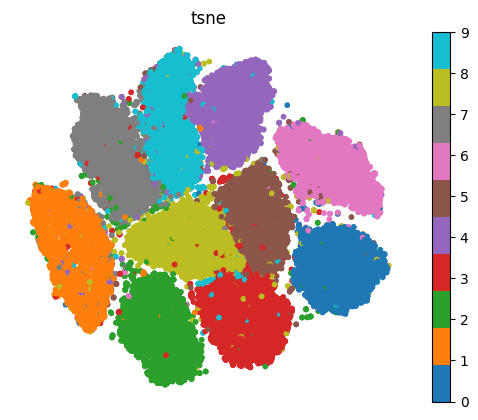

In [25]:
import matplotlib.pyplot as plt

plt.scatter(X_train_tsne[:,0],X_train_tsne[:,1], c=y_train.astype(int), cmap='tab10', s=10)
plt.axis('off')
plt.colorbar()
plt.title('tsne')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

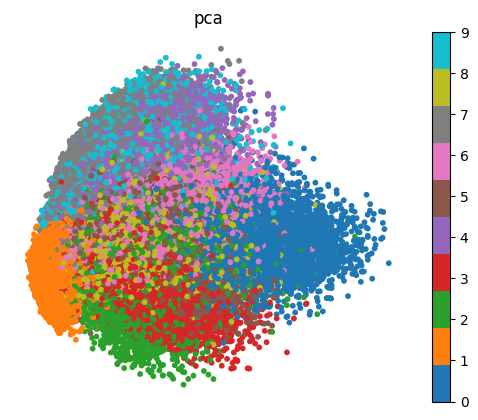

In [26]:
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], c=y_train.astype(int), cmap='tab10', s=10)
plt.axis('off')
plt.colorbar()
plt.title('pca')
plt.show

/Users/juan/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

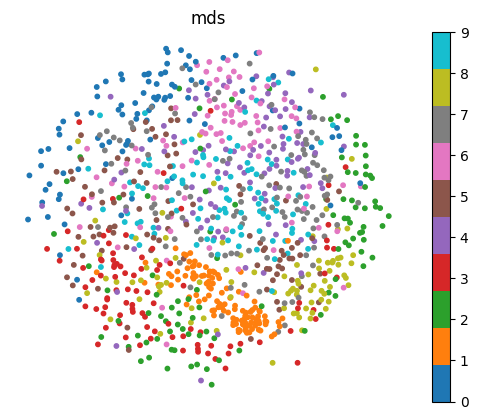

In [27]:
from sklearn.manifold import MDS 

X_reduced = X[:1000]
y_reduced = y[:1000]

mds = MDS(n_components = 2)
X_train_mds = mds.fit_transform(X_reduced)

plt.scatter(X_train_mds[:,0],X_train_mds[:,1], c=y_reduced.astype(int), cmap='tab10', s=10)
plt.axis('off')
plt.colorbar()
plt.title('mds')
plt.show

# Preguntas teóricas
### Métodos de ensamble

1. Si ha entrenado cinco modelos diferentes en los mismos datos de entrenamiento y todos logran una precisión del 95%, ¿existe alguna posibilidad de combinar estos modelos para obtener mejores resultados? Si es así, ¿cómo? Si no, ¿por qué?

- Si todos logran el 95% precisión, podemos intentar combinarlos en un conjunto de votación, que a menudo dará mejores resultados. Funciona mejor si los modelos son muy diferentes (por ejemplo, un clasificador SVM, una Decisión clasificador de árbol, un clasificador de regresión logística, etc.). Es
incluso mejor si están entrenados en diferentes instancias de entrenamiento (ese es el objetivo de embolsar y pegar conjuntos), pero si no, esto seguirá siendo efectivo siempre que los modelos sean muy
diferentes.



2. ¿Cuál es la diferencia entre los clasificadores de votación hard y de votación soft?

- Un clasificador de votación `hard` simplemente cuenta los votos de cada clasificador en el conjunto y elige la clase que recibe la mayoría de los votos. Un clasificador de votación `soft` calcula la probabilidad media estimada para cada clase y elige la clase con la probabilidad más alta. Esto otorga más peso a los votos de alta confianza y a menudo tiene un mejor rendimiento, pero solo funciona si cada clasificador es capaz de estimar las probabilidades de clase (por ejemplo, para los clasificadores SVM en Scikit-Learn, hay que establecer probability=True).




3. ¿Es posible acelerar el entrenamiento de un conjunto de bagging distribuyéndolo en varios servidores? ¿Qué pasa con los conjuntos de pasting, los conjuntos de boosting, los Random Forest o los ensambles Stacking?

- Es posible acelerar el entrenamiento de un conjunto de `bagging` distribuyéndolo en varios servidores, ya que cada predictor en el ensamblado es independiente de los demás. Lo mismo ocurre con los ensamblados `pasting` y los RandomForest, por la misma razón. Sin embargo, cada predictor en un ensamblado `boosting` se construye en función del predictor anterior, por lo que el entrenamiento es necesariamente secuencial y no se obtendrá ningún beneficio al distribuir el entrenamiento en múltiples servidores. En cuanto a los ensamblados `stacking`, todos los predictores en una capa dada son independientes entre sí, por lo que se pueden entrenar en paralelo en varios servidores. Sin embargo, los predictores en una capa solo se pueden entrenar después de que todos los predictores en la capa anterior hayan sido entrenados.


4. ¿Cuál es el beneficio de la evaluación out-of-bag (OOB)?

- Con la evaluación `out-of-bag (fuera de la bolsa)`, cada predictor en un conjunto de ensamblado bagging es evaluado utilizando instancias en las que no fue entrenado (se mantuvieron aparte). Esto permite tener una evaluación bastante imparcial del ensamblado sin necesidad de un conjunto de validación adicional. De esta manera, tienes más instancias disponibles para el entrenamiento y tu ensamblado puede tener un rendimiento ligeramente mejor.


5. ¿Qué hace que los Extra-Trees sean más aleatorios que los Random Forest regulares? ¿Cómo puede esta aleatoriedad adicional ayudar? ¿Son los Extra-Trees más lentos o más rápidos que los Random Forest regulares?

- Cuando estás desarrollando un árbol en un RandomForest, solo se considera un subconjunto aleatorio de las características para dividir en cada nodo. Esto también es cierto para los Extra-Forest, pero van un paso más allá: en lugar de buscar los umbrales óptimos posibles, como lo hacen los DecisionTrees regulares, utilizan umbrales aleatorios para cada característica. Esta aleatoriedad adicional actúa como una forma de regularización: si un RandomForest se ajusta demasiado a los datos de entrenamiento, los Extra-Forest podrían tener un mejor rendimiento. Además, dado que los Extra-Forest no buscan los umbrales óptimos posibles, son mucho más rápidos de entrenar que los Random-Forest. Sin embargo, ni son más rápidos ni más lentos que los Random-Forest al realizar predicciones.




6. Si su conjunto de AdaBoost no se ajusta lo suficientemente bien a los datos de entrenamiento, ¿qué hiperparámetros debe ajustar y cómo?

- Si tu conjunto de ensamblado AdaBoost se ajusta insuficientemente a los datos de entrenamiento, puedes intentar aumentar el número de estimadores o reducir los hiperparámetros de regularización del estimador base. También puedes probar ligeramente aumentar la tasa de aprendizaje.


7. Si su conjunto de Gradient Boosting sobreajusta el conjunto de entrenamiento, ¿debería aumentar o disminuir la tasa de aprendizaje?

- Si tu conjunto de ensamblado de Gradient Boosting se ajusta demasiado a los datos de entrenamiento, deberías intentar disminuir la tasa de aprendizaje. También podrías utilizar la detención temprana (early stopping) para encontrar el número adecuado de predictores (probablemente tienes demasiados).




### Reducción dimensional

1. ¿Cuáles son las principales motivaciones para reducir la dimensionalidad de un conjunto de datos? ¿Cuáles son las principales desventajas?

- Agilizar el algoritmo de entrenamiento subsiguiente (en algunos casos, incluso puede eliminar ruido y características redundantes, lo que hace que el algoritmo de entrenamiento tenga un mejor rendimiento).

- Visualizar los datos y obtener información sobre las características más importantes.

- Ahorrar espacio (compresión).


`Las principales desventajas son:`

- Se pierde cierta información, lo que puede degradar el rendimiento de los algoritmos de entrenamiento subsiguientes.
- Puede requerir una alta carga computacional.
- Añade cierta complejidad a los flujos de trabajo de Aprendizaje Automático.
- Las características transformadas suelen ser difíciles de interpretar.

2. ¿En qué consiste la maldición de la dimensionalidad?

- La maldición de la dimensionalidad hace referencia al hecho de que muchos problemas que no existen en espacios de baja dimensionalidad surgen en espacios de alta dimensionalidad. En ML, una manifestación común es que los vectores de alta dimensionalidad muestreados aleatoriamente suelen ser muy dispersos, lo que aumenta el riesgo de sobreajuste y dificulta la identificación de patrones en los datos sin contar con suficientes datos de entrenamiento.

3. Una vez que se ha reducido la dimensionalidad de un conjunto de datos, ¿es posible revertir la operación? En caso afirmativo, ¿cómo? En caso contrario, ¿por qué?

- Una vez que se ha reducido la dimensionalidad de un conjunto de datos utilizando uno de los algoritmos mencionados, casi siempre es imposible revertir completamente la operación, ya que se pierde cierta información durante la reducción de dimensionalidad. Además, aunque algunos algoritmos (como PCA) tienen un procedimiento de transformación inversa simple que puede reconstruir un conjunto de datos relativamente similar al original, otros algoritmos (como T-SNE) no lo tienen.

4. ¿Se puede utilizar PCA para reducir la dimensionalidad de un conjunto de datos altamente no lineal?

- PCA se puede utilizar para reducir significativamente la dimensionalidad de la mayoría de los conjuntos de datos, incluso si son altamente no lineales, porque al menos puede eliminar dimensiones inútiles. Sin embargo, si no hay dimensiones inútiles, como en un conjunto de datos en forma de rollo suizo, reducir la dimensionalidad con PCA perderá demasiada información. En este caso, se quiere desenrollar el rollo suizo, no aplastarlo.

5. Supongamos que realizas PCA en un conjunto de datos de 1,000 dimensiones, estableciendo el ratio de varianza explicada en 95%. ¿Cuántas dimensiones tendrá el conjunto de datos resultante?

- Esa es una pregunta trampa: depende del conjunto de datos. Veamos dos ejemplos extremos. Primero, supongamos que el conjunto de datos está compuesto por puntos casi perfectamente alineados. En este caso, PCA puede reducir el conjunto de datos a solo una dimensión mientras se preserva el 95% de la varianza. Ahora, imaginemos que el conjunto de datos está compuesto por puntos perfectamente aleatorios, dispersos en las 1,000 dimensiones. En este caso, se necesitarán aproximadamente 950 dimensiones para preservar el 95% de la varianza. Por lo tanto, la respuesta es que depende del conjunto de datos y podría ser cualquier número entre 1 y 950. Graficar la varianza explicada en función del número de dimensiones es una forma de tener una idea aproximada de la dimensionalidad intrínseca del conjunto de datos.

6. ¿En qué casos utilizarías PCA convencional, PCA incremental, PCA aleatorio o PCA kernel?

- PCA regular es el enfoque predeterminado, pero solo funciona si el conjunto de datos cabe en memoria. PCA incremental es útil para conjuntos de datos grandes que no caben en memoria, pero es más lento que PCA regular, por lo que si el conjunto de datos cabe en memoria, se debe preferir PCA regular. PCA incremental también es útil para tareas en línea, cuando se necesita aplicar PCA sobre la marcha cada vez que llega una nueva instancia. PCA aleatorio es útil cuando se desea reducir considerablemente la dimensionalidad y el conjunto de datos cabe en memoria; en este caso, es mucho más rápido que PCA regular. Finalmente, PCA kernel es útil para conjuntos de datos no lineales.

7. ¿Cómo puedes evaluar el rendimiento de un algoritmo de reducción dimensional en tu conjunto de datos?

- En términos intuitivos, un algoritmo de reducción de dimensionalidad tiene un buen rendimiento si elimina muchas dimensiones del conjunto de datos sin perder demasiada información. Una forma de medir esto es aplicar la transformación inversa y medir el error de reconstrucción. Sin embargo, no todos los algoritmos de reducción de dimensionalidad proporcionan una transformación inversa. Alternativamente, si estás utilizando la reducción de dimensionalidad como paso previo al algoritmo de Aprendizaje Automático (por ejemplo, un clasificador de Bosques Aleatorios), simplemente puedes medir el rendimiento de ese segundo algoritmo; si la reducción de dimensionalidad no pierde demasiada información, entonces el algoritmo debería tener un rendimiento igual de bueno que al utilizar el conjunto de datos original.


8. ¿Tiene sentido encadenar dos algoritmos de reducción dimensional diferentes?

- Tiene mucho sentido encadenar dos algoritmos de reducción de dimensionalidad diferentes. Un ejemplo común es utilizar PCA para deshacerse rápidamente de un gran número de dimensiones inútiles y luego aplicar otro algoritmo de reducción de dimensionalidad mucho más lento, como LLE. Este enfoque de dos pasos probablemente producirá el mismo rendimiento que utilizar solo LLE, pero en una fracción del tiempo. 